In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset
import torch.nn as nn

import matplotlib.pyplot as plt

# 1. define your dataloader

In [2]:
transform_list = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.131], std=[0.289])])
dataset = datasets.MNIST(root='/tmp/', train=True, download=True, transform=transform_list)
dataset = Subset(dataset, range(2000))

loader = torch.utils.data.DataLoader(
      dataset=dataset,
      batch_size=500,
      shuffle=False)

# 2. define your model

In [3]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.flatten(1)

n_hidden = 2
hidden_size = 10
device = 'cuda'
layers = [Flatten(), nn.Linear(28 * 28, hidden_size), nn.ReLU()] + \
         [nn.Linear(hidden_size, hidden_size), nn.ReLU()] * (n_hidden - 1) + \
         [nn.Linear(hidden_size, 10), nn.LogSoftmax(dim=1)]
model = nn.Sequential(*layers).to(device)

# 3. define your loss function
For this example here we will compute the MC-sampled Fisher Information Matrix using only 1 sample for each example.

In [4]:
def loss_fim_mc_estimate(input, target):
    log_sm = model(input)
    probs = torch.exp(log_sm)
    random_target = torch.multinomial(probs, 1)
    random_log_sm = torch.gather(log_sm, 1, random_target)
    return random_log_sm.sum()

# 4. create your generator

In [5]:
from nngeometry.pspace import L2Loss

l2_generator = L2Loss(model=model, dataloader=loader, loss_closure=loss_fim_mc_estimate)
n_parameters = l2_generator.get_n_parameters()
print(str(n_parameters) + ' parameters')

8070 parameters


# 5. choose a representation

# 5.1 DenseMatrix representation

In [6]:
from nngeometry.representations import DenseMatrix

F_dense = DenseMatrix(l2_generator)
F = F_dense.get_matrix()

display the end of the FIM (corresponding to the last layer)

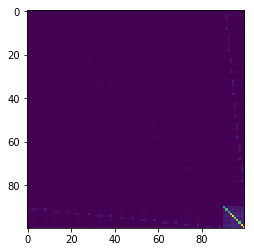

In [7]:
plt.imshow(torch.abs(F)[-100:,-100:].cpu())

display the top 50 eigenvalues (eigenvalues are computed using symeig by default so they are in increasing order)

In [8]:
F_dense.compute_eigendecomposition()
evals, evecs = F_dense.get_eigendecomposition()

Text(0, 0.5, 'eigenvalue')

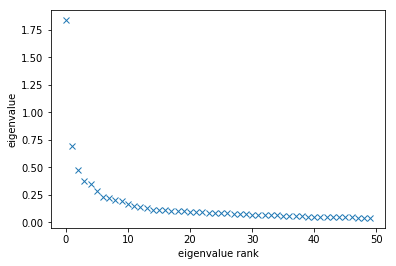

In [9]:
plt.plot(evals[-50:].cpu().numpy()[::-1], marker='x', linestyle="None")
plt.xlabel('eigenvalue rank')
plt.ylabel('eigenvalue')

compute $\sqrt{\mathbf{v}^\top F \mathbf{v}}$ for a random vector $\mathbf{v}$

In [10]:
from nngeometry.vector import Vector

v_flat = torch.rand((n_parameters)).to(device)

v = Vector(model, vector_repr=v_flat)
print(F_dense.m_norm(v))

tensor(7.5154, device='cuda:0')


compute the trace and frobenius norm of $F$

In [11]:
print(F_dense.trace(), F_dense.frobenius_norm())

tensor(12.0876, device='cuda:0') tensor(2.2273, device='cuda:0')


in the DenseMatrix representation the matrix is evaluated once at initialization, and so several calls to the same function will result in the same value, even in the current case where we only get a MC estimator, and not a deterministic formula:

In [12]:
print(F_dense.trace(), F_dense.trace())

tensor(12.0876, device='cuda:0') tensor(12.0876, device='cuda:0')


# 5.2 ImplicitMatrix representation

In this representation the matrix is never computed or stored in memory but instead the operations are performed implicitly. This allows to compute e.g. $\sqrt{\mathbf{v}^\top F \mathbf{v}}$ where $F$ would be too large to store in memory.

In [13]:
from nngeometry.representations import ImplicitMatrix

F_implicit = ImplicitMatrix(l2_generator)

In [14]:
print(F_implicit.m_norm(v), F_implicit.trace())

tensor(7.3260, device='cuda:0') tensor(11.9335, device='cuda:0')


note that in the case of a Monte Carlo estimate of the FIM, and contrary to the DenseMatrix representation, here several calls to the same function can result in different estimates. This is because each function call will loop through all examples and compute the loss by sampling from the model, contrary to the DenseMatrix representation where the matrix is computed only once at init.

In [15]:
print(F_implicit.trace(), F_implicit.trace())

tensor(12.2205, device='cuda:0') tensor(11.8498, device='cuda:0')


# 5.3 KFACMatrix representation

In [16]:
from nngeometry.representations import KFACMatrix

F_kfac = KFACMatrix(l2_generator)

display the end of the FIM (corresponding to the last layer)

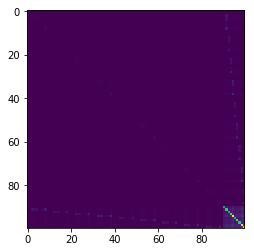

In [17]:
plt.imshow(torch.abs(F_kfac.get_matrix(split_weight_bias=True))[-100:,-100:].cpu())

compute $\sqrt{\mathbf{v}^\top F \mathbf{v}}$ for a random vector $\mathbf{v}$. Note the slight difference with the DenseMatrix above since KFAC is an approximation

In [18]:
print(F_kfac.m_norm(v))

tensor(8.0206, device='cuda:0')


In [19]:
print(F_kfac.trace())

tensor(12.1591, device='cuda:0')
